# n_obs

n_obs is designed to produce a series of counters that show how many measurements are made at a given site.

In [3]:
#import required libraries
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## `count_nobs()`
`count_nobs()` counts the number of observations for a given station.

### Inputs
- station name as string `station`, formatted as you would like it displayed, consistent with hardcoded special cases and dictionaries from `draw_nobs()`.
- mode as string `mode`, either `'SST'` or `'SBT'` (Scripps Pier only)
- filename(s) of Excel spreasheets containing data to access as string(s) `*args`, one file unless Trinidad Bay & Beach.

### Algorithm
1. Check to determine if case is special case.  If special case, follow specific instructions for that case.  Special cases include Scripps Pier (SST & SBT) and Trinidad Beack & Bay (two files).  If not a special case, follow general instructions.
2. Open the applicable file(s).  To make the columns have meaningful names, `skip_rows()` iteratively looks for the number of header rows to exclude so the first column is named `'YEAR'`.
3. Count number of observations.

### Outputs
A list containing the number of observations as string `obs_count`, the text identifying the station and how long it's been there as string `bottom_text`, the station name as string `station` and the mode as string `mode`.


In [8]:
def count_nobs(station, mode, *filenames):
    def skip_rows(filename): #There is definitely a smarter way to do this, but I was lazy
        df = pd.read_excel(filename)
        n_rows = df.shape[0]
        for i in range(1, n_rows):
            df = pd.read_excel(filename, skiprows=i)
            if df.iloc[0][0] == 'YEAR':
                break
        skiprows = i + 1
        return skiprows

    if station == 'Trinidad Beach & Bay': #Special case: Trinidad Beach & Bay needs to read 2 files
        obs_count = 0
        for filename in filenames:
            skiprows = skip_rows(filename)
            df = pd.read_excel(filename, skiprows=skiprows)
            obs_count += df.shape[0]
    elif station == 'Scripps Pier': #Special case: Scripps Pier has SST and SBT
        skiprows = skip_rows(filenames[0])
        df = pd.read_excel(filenames[0], skiprows=skiprows)
        if mode == 'SST':
            obs_count = df.shape[0]
        elif mode == 'SBT':
            obs_count = np.count_nonzero(~np.isnan(df.BOT_TEMP_C.values))
    else: #normal cases
        skip_rows = skip_rows(filenames[0])
        df = pd.read_excel(filenames[0], skiprows=skip_rows)
        obs_count = df.shape[0]
    return [str(obs_count), station]

### A few examples of the behavior of `count_nobs`

Normal case: Farallon Islands

In [9]:
farallons = count_nobs('Farallon Islands', 'SST', 'Farallons_TEMP_1925-20230703.xls')
farallons

['35855', 'Farallon Islands']

Special case: Scripps Pier has both SST and SBT measurements on the same spreadsheet

In [5]:
scripps_SST = count_nobs('Scripps Pier', 'SST', 'SIO_TEMP_20230501.xls')
scripps_SBT = count_nobs('Scripps Pier', 'SBT', 'SIO_TEMP_20230501.xls')
scripps_SST, scripps_SBT

(('38968',
  'SST observations at Scripps Pier since 1916',
  'Scripps Pier',
  'SST'),
 ('33186',
  'SBT observations at Scripps Pier since 1916',
  'Scripps Pier',
  'SBT'))

Special case: Trinidad Beach & Bay are counted as one "station" but have two spreadsheets

In [13]:
trinidad = count_nobs('Trinidad Beach & Bay', 'SST', 'TrinidadBeach_TEMP_1975-20230622.xls', 'TrinidadBeach_TEMP_1975-20230622.xls') #TODO replace one filename with Trinidad Bay file, here just using Trinidad Beach as a dummy
trinidad

('35366',
 'SST observations',
 'at Trinidad Beach and Bay since 1973',
 'Trinidad Beach & Bay',
 'SST')

## `draw_nobs()`
`draw_nobs()` generates and saves a visualization depicting observation counts along with corresponding station and mode information.

### Inputs
- `count_n_obs`: A list containing observation count, bottom text, station name, and mode as its elements.

### Algorithm
1. Extract the observation count, bottom text, station name, and mode from the `count_n_obs` list.
2. Define dictionaries containing styling parameters like font sizes, font positions, and image heights for different station and mode combinations.
3. Construct a unique key for the dictionaries using the station name and mode.
4. Create a new figure and axes for the plot with a predefined image height and resolution.
5. Configure plot limits, turn off axis display, and add annotations for the observation count and bottom text.
6. Convert the station and mode combination into a filename-friendly format.
7. Save the plot as an image file.
8. Open the saved image, crop it to remove excess whitespace, and save the cropped image.

### Outputs
A PNG image file representing the visualization of observation counts for the given station and mode. The filename is derived from the station and mode information.

In [12]:
def draw_nobs(nobs):
    obs_count = nobs[0]
    station = nobs[1]
    fig, ax = plt.subplots(figsize=(1,0.1), dpi=400)

    x = np.arange(0, 10, 0.1)
    y = 1

    ax.plot(y, color='blue', label='Sine wave')

    plt.xlim([0, 50])
    plt.ylim([0, 20])

    plt.axis('off')

    plt.annotate(obs_count[0:2]+','+obs_count[2:], fontsize = 85, c='hotpink', xy=(.1,.9), xycoords="axes fraction") #TODO Change to hot pink
    filename = station+'.png'
    plt.savefig(filename, bbox_inches='tight', dpi=400)
    
    uncropped = Image.open(filename)
    image_box = uncropped.getbbox()
    cropped = uncropped.crop(image_box)
    cropped.save(filename)

### Example behavior for `draw_nobs`

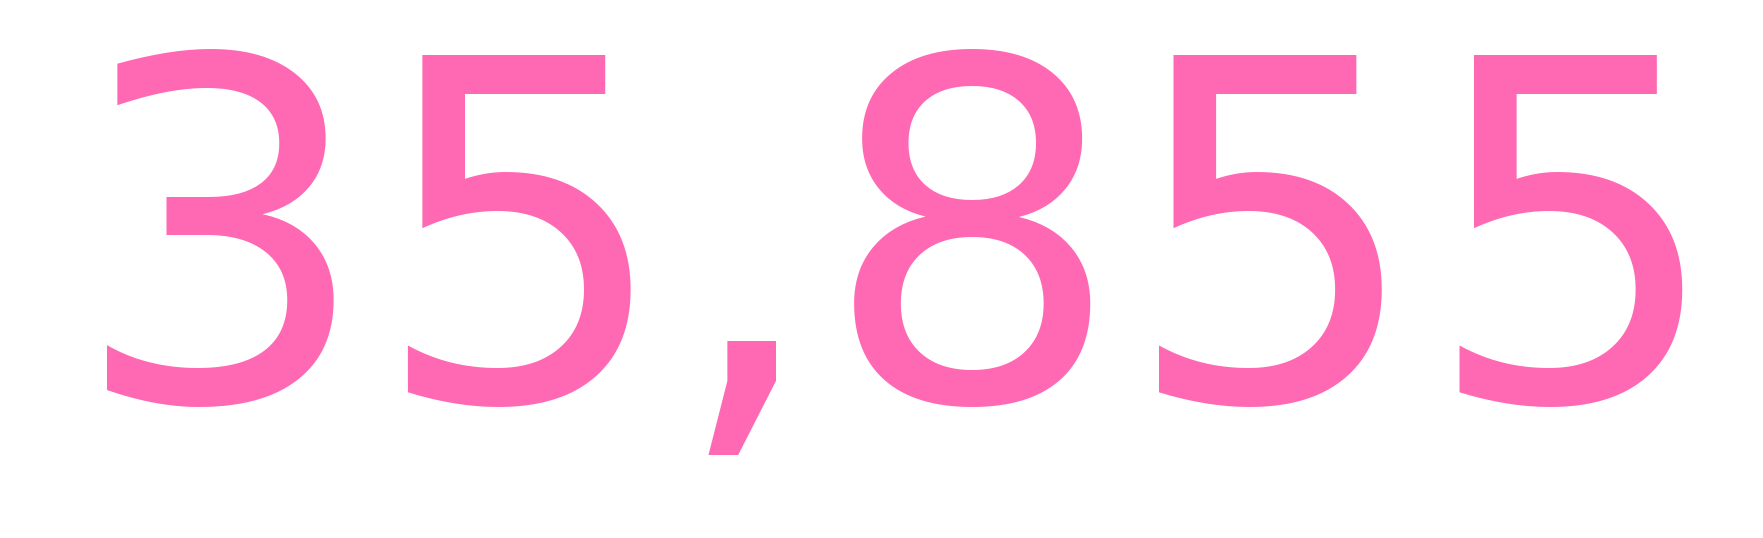

In [13]:
draw_nobs(farallons)